## Imports and Some Settings

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.optimizers as opti
import tensorflow.keras.activations as acti
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True))
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 980, pci bus id: 0000:26:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Loading Data:

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Some Consts:

In [3]:
IMG_PX = 28
LOGS_PATH = "./logs_digit_mnist/"
DEF_LR = 1e-5
DEF_STEPS = 1e6
DEF_EPOCHS = 50
DEF_BATCH_SIZE = 64
NUM_CLASSES = 10
FEATURE_COLUMNS = [tf.feature_column.numeric_column("x", shape=[IMG_PX, IMG_PX])]

## Dataset Preview:

In [4]:
def display_first_M_x_N_images(data,M=4,N=4):
    '''
    Displays first 16 images froma given data
    at the MxN figure
    :param data: given data
    :param M: number of columns
    :param N: number of rows
    '''
    fig = plt.figure(figsize=(13, 13))
    axes=[]
    plt.gray()
    for ii in range(M*N):
        axes.append(fig.add_subplot(M, N, ii + 1))
        plt.imshow(data[ii].reshape((28,28)))
    plt.tight_layout()

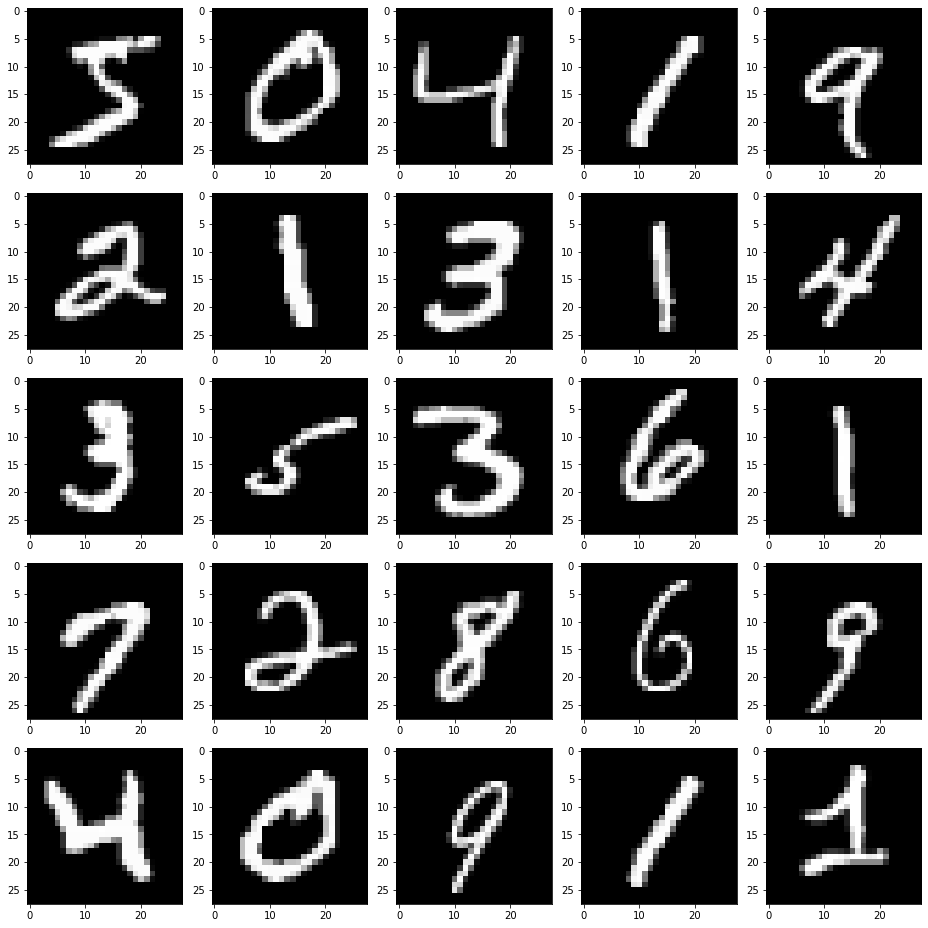

In [5]:
display_first_M_x_N_images(X_train, 5, 5)

## Input Functions

In [6]:
def make_input_fn(X, y, num_epochs=1, batch_size=DEF_BATCH_SIZE, shuffle=False):
    '''
    Generates function, that will be called
    during training/evaluation of each classifier.
    :param X: given data
    :param y: data labels
    :param num_epochs: number of epochs
    :param batch_size: number of batch
    :param shuffle: tells if given data should be shuffled
    :return: specified input function
    '''
    input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
        x = {"x": X},
        y = y.astype('int32'),
        num_epochs=num_epochs,
        batch_size=batch_size,
        shuffle=shuffle)
    return input_fn

train_input_fn = make_input_fn(X_train, y_train, num_epochs=None, shuffle=True)
test_input_fn = make_input_fn(X_test, y_test)

## Model's Callbacks Path Generator

In [7]:
def callback_path(name):
    '''
    Generates path to folder in which will
    be saved all models training and evaluation checkpoints:
    right path + name + actual time
    :param name: classifier name
    :return: path
    '''
    curr_time = datetime.now().strftime("%H_%M_%S")
    return LOGS_PATH + name + "_" + curr_time

for_example = callback_path("Ultra_Classifier")
for_example

'./logs_digit_mnist/Ultra_Classifier_00_06_51'

# All Models' Names That I Will Test Here:

In [8]:
LINEAR_CLASSIFIER_NAME = "linear_classifier"
DNN_LINEAR_COMBINED_CLASSIFIER_1000_1000_NAME = "dnn_linear_combined_classifier_1000_1000"
DNN_LINEAR_COMBINED_CLASSIFIER_300_300_100_NAME = "dnn_linear_combined_classifier_300_300_100"
DNN_CLASSIFIER_6_LAYERS_SIMPLE_NAME = "dnn_classifier_6_layers_simple"
DNN_CLASSIFIER_6_LAYERS_ADVANCED_NAME = "dnn_classifier_6_layers_advanced"
BASELINE_CLASSIFIER_ADAM_NAME = "baseline_classifier_adam"
BASELINE_CLASSIFIER_FTRL_NAME = "baseline_classifier_ftrl"

NN_1000_1000_NAME = "nn_1000_1000"
NN_300_300_100_NAME = "nn_300_300_100"
NN_6_LAYERS_NAME = "nn_6_layers"


NAMES = [LINEAR_CLASSIFIER_NAME,DNN_LINEAR_COMBINED_CLASSIFIER_1000_1000_NAME,DNN_LINEAR_COMBINED_CLASSIFIER_300_300_100_NAME,
        DNN_CLASSIFIER_6_LAYERS_SIMPLE_NAME,DNN_CLASSIFIER_6_LAYERS_ADVANCED_NAME,BASELINE_CLASSIFIER_ADAM_NAME,
        BASELINE_CLASSIFIER_FTRL_NAME,NN_1000_1000_NAME,NN_300_300_100_NAME,NN_6_LAYERS_NAME]

## Linear Classifier Model:

In [9]:
linear_classifier = tf.estimator.LinearClassifier(
    feature_columns=FEATURE_COLUMNS,
    optimizer=opti.Adam(lr=DEF_LR),
    n_classes=NUM_CLASSES,
    model_dir=callback_path(LINEAR_CLASSIFIER_NAME)
)

## DNN Linear Combined Classifier Models:

In [10]:
def generator_dnn_linear_combined(name, lin_optimizer, dnn_optimizer, 
                                  dnn_activation, dnn_hidden_units,
                                  feat_columns=FEATURE_COLUMNS, n_classes=NUM_CLASSES):
    """
    It generates dnn linear combined classifiers. 
    It just generates new models of this kind.
    I thought that those models would be better
    than just simple Linear Classifier
    :param name: model's name
    :param lin_optimizer: linear optimizer
    :param dnn_optimizer: dnn optimizer
    :param dnn_activation: dnn activation function
    :param dnn_hidden_units: list of units in each hidden layer
    :param feat_columns: feature columns
    :param n_classes: number of classes
    :return: new DNNLinearCombined model
    """
    return tf.estimator.DNNLinearCombinedClassifier( 
        linear_optimizer=lin_optimizer,
        dnn_optimizer=dnn_optimizer, 
        dnn_activation_fn=dnn_activation, 
        dnn_hidden_units=dnn_hidden_units,
        linear_feature_columns=feat_columns,
        dnn_feature_columns=feat_columns, 
        n_classes=NUM_CLASSES,
        model_dir=callback_path(name)
    )

In [11]:
dnn_linear_combined_classifier_1000_1000 = generator_dnn_linear_combined(
    name=DNN_LINEAR_COMBINED_CLASSIFIER_1000_1000_NAME, 
    lin_optimizer=opti.Adam(lr=DEF_LR), 
    dnn_optimizer=opti.Adam(lr=DEF_LR),
    dnn_activation=acti.relu, 
    dnn_hidden_units=[1000,1000]
)

In [12]:
dnn_linear_combined_classifier_300_300_100 = generator_dnn_linear_combined(
    name=DNN_LINEAR_COMBINED_CLASSIFIER_300_300_100_NAME, 
    lin_optimizer=opti.Adam(lr=DEF_LR), 
    dnn_optimizer=opti.Adam(lr=DEF_LR),
    dnn_activation=acti.relu, 
    dnn_hidden_units=[300,300,100]
)

## DNN Classifier Models:

In [13]:
def generator_dnn(name, optimizer, activation, hidden_units,
                  dropout=None, feat_columns=FEATURE_COLUMNS, n_classes=NUM_CLASSES):
    """
    It generates dnn classifiers. This method helps me 
    in making easly new classifiers of this kind
    :param name: model's name
    :param optimizer: model's optimizer
    :param activation: model's activation function
    :param hidden_units: list of units in each hidden layer
    :param feat_columns: feature columns
    :param n_classes: number of classes
    :return: new DNNClassifier model
    """
    return tf.estimator.DNNClassifier(
        optimizer=optimizer,
        activation_fn=activation,
        hidden_units=hidden_units, 
        dropout=dropout,
        feature_columns=feat_columns, 
        n_classes=n_classes, 
        model_dir=callback_path(name),
    )

In [14]:
dnn_classifier_6_layers_simple = generator_dnn(
    name=DNN_CLASSIFIER_6_LAYERS_SIMPLE_NAME,
    optimizer=opti.SGD(learning_rate=DEF_LR),
    activation= acti.sigmoid,
    hidden_units=[784,2500,2000,1500,1000,500,10]
)

In [15]:
dnn_classifier_6_layers_advanced = generator_dnn(
    name=DNN_CLASSIFIER_6_LAYERS_ADVANCED_NAME,
    optimizer=opti.Adam(lr=DEF_LR),
    activation= acti.relu,
    hidden_units=[784,2500,2000,1500,1000,500,10],
    dropout=0.1)

## Baseline Classifier Models: 
### Yes, it is not the right choice. But hey, it says: "Classifier", I will give it a try, even though it won't end well

In [16]:
def generator_baseline(name, optimizer, feat_columns=FEATURE_COLUMNS, n_classes=NUM_CLASSES):
    """
    It generates baseline classifiers. 
    This method's purpose is to make it easier for
    me in the future to genereate models of this kind with
    different optimizers, or even for totally different problem
    :param name: model's name
    :param optimizer: model's optimizer
    :param feat_columns: feature columns
    :param n_classes: number of classes
    :return: new BaselineClassifier model
    """
    return tf.estimator.BaselineClassifier(
        optimizer=optimizer,
        n_classes=n_classes,
        model_dir=callback_path(name)
    )

In [17]:
baseline_classifier_adam = generator_baseline(
    name=BASELINE_CLASSIFIER_ADAM_NAME,
    optimizer=opti.Adam)

In [18]:
baseline_classifier_ftrl = generator_baseline(
    name=BASELINE_CLASSIFIER_FTRL_NAME,
    optimizer=opti.Ftrl)

## Neural Networks Models:

In [19]:
nn_1000_1000 = tf.keras.Sequential([
    layers.Flatten(input_shape=(IMG_PX, IMG_PX)),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(10, activation='softmax')
])

nn_1000_1000.compile(optimizer=opti.Adam(lr=DEF_LR),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

In [20]:
nn_300_300_100 = tf.keras.Sequential([
    layers.Flatten(input_shape=(IMG_PX, IMG_PX)),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')
])

nn_300_300_100.compile(optimizer=opti.Adam(lr=DEF_LR),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [21]:
nn_6_layers = tf.keras.Sequential([
    layers.Flatten(input_shape=(IMG_PX, IMG_PX)),
    layers.Dense(784, activation='relu'),
    layers.Dense(2500, activation='relu'),
    layers.Dense(2000, activation='relu'),
    layers.Dense(1500, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

nn_6_layers.compile(optimizer=opti.Adam(lr=DEF_LR),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

## Convolutional Neural Networks Models:

## Training / Fitting Functions With Time Counter

In [22]:
def run_classifier_training(classifier, input_fn, steps, name):
    """
    This function counts how long does the given
    classifier work (how long does the training take), 
    also it returns the results
    :param classifier: classifier to train
    :param input_fn: input function
    :param steps: number of steps
    :param name: Name of the classifier
    :return: results of given classifier
    """
    start = time.perf_counter()
    res = classifier.train(input_fn=input_fn, steps=steps)
    total = time.perf_counter() - start
    total = round(total * 1000)/1000
    print(f"{name} => {total}s")
    return res

def run_nn_fitting(nn, X, y, epochs, batch_size, name, verbose=0):
    """
    This function counts how long does the given
    neural network work (how long does the fitting take), 
    also it returns the results
    :param nn: neural network to fit
    :param X: dataset
    :param y: labels
    :param epochs: number of epochs
    :param batch_size: size of batch :o
    :param name: Name of the nn
    :param verbose: 0 - silent fittine, 1 "loud" fitting
    :return: results of given nn
    """
    tensorboard = TensorBoard(log_dir=callback_path(name))
    start = time.perf_counter()
    res = nn.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[tensorboard], verbose=verbose)
    total = time.perf_counter() - start
    total = round(total * 1000)/1000
    print(f"{name} => {total}s")
    return res

## All Models Training / Fitting:

In [23]:
DEF_EPOCHS=1
DEF_STEPS=1000

In [24]:
CLASSIFIERS = [linear_classifier, dnn_linear_combined_classifier_1000_1000, dnn_linear_combined_classifier_300_300_100,
              dnn_classifier_6_layers_simple, dnn_classifier_6_layers_advanced, baseline_classifier_adam,
              baseline_classifier_ftrl]

NNS = [nn_1000_1000, nn_300_300_100, nn_6_layers]

In [25]:
classifiers_stories = [run_classifier_training(CLASSIFIERS[ii], train_input_fn, DEF_STEPS, NAMES[ii]) 
                       for ii in range(len(CLASSIFIERS))]

nns_stories = [run_nn_fitting(NNS[ii], X_train, y_train, DEF_EPOCHS, DEF_BATCH_SIZE, NAMES[ii + len(CLASSIFIERS)]) 
                       for ii in range(len(NNS))]

linear_classifier => 2.266s
dnn_linear_combined_classifier_1000_1000 => 3.558s
dnn_linear_combined_classifier_300_300_100 => 2.964s
dnn_classifier_6_layers_simple => 6.606s
dnn_classifier_6_layers_advanced => 10.29s
baseline_classifier_adam => 1.923s
baseline_classifier_ftrl => 1.905s
nn_1000_1000 => 2.334s
nn_300_300_100 => 1.978s
nn_6_layers => 6.117s


## All Models Evaluation:

In [26]:
#test_loss, test_acc = nn_1000_1000.evaluate(X_test, y_test, verbose=1) 
#print('Test accuracy:', test_acc)

## Loss Function Plots:

## Results Comparison: